# Generate H5AD Input

2022-10-12

In [1]:
# Import Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from anndata import AnnData

# Customized packages
import starmap.sc_util as su

# test()

## Input

In [2]:
# Set path
base_path = 'Z:/Data/Analyzed/2022-09-06-Rena-TEMPOmap1000GeneHeLa3/'

out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(base_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

# Load whole cell data
primary_dataset = 'whole_cell'
expr_path = os.path.join(out_path, primary_dataset, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, primary_dataset, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, primary_dataset, 'complete_meta.csv')

# Add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

adata = AnnData(X=expr_x, var=var, obs=obs)

In [3]:
adata

AnnData object with n_obs × n_vars = 17751 × 998
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z'

In [4]:
# Load nucleus data
primary_dataset = 'nucleus'
expr_path = os.path.join(out_path, primary_dataset, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, primary_dataset, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, primary_dataset, 'complete_meta.csv')

# Add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

nucdata = AnnData(X=expr_x, var=var, obs=obs)

In [5]:
# Load cytoplasm data
primary_dataset = 'cytoplasm'
expr_path = os.path.join(out_path, primary_dataset, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, primary_dataset, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, primary_dataset, 'complete_meta.csv')

# Add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

cytodata = AnnData(X=expr_x, var=var, obs=obs)

In [6]:
# Load outer_cytoplasm data
primary_dataset = 'outer_cytoplasm'
expr_path = os.path.join(out_path, primary_dataset, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, primary_dataset, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, primary_dataset, 'complete_meta.csv')

# Add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

out_cytodata = AnnData(X=expr_x, var=var, obs=obs)

In [7]:
# Load er data
primary_dataset = 'er'
expr_path = os.path.join(out_path, primary_dataset, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, primary_dataset, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, primary_dataset, 'complete_meta.csv')

# Add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

erdata = AnnData(X=expr_x, var=var, obs=obs)

## QC

In [11]:
# Remove cells without ER structure 
cells_to_keep = erdata.obs['volume'] != 0 

# Subset 
adata = adata[cells_to_keep, ]
adata.layers['nucleus'] = nucdata[cells_to_keep, ].X
adata.layers['cytoplasm'] = cytodata[cells_to_keep, ].X
adata.layers['er'] = erdata[cells_to_keep, ].X
adata.layers['outer_cytoplasm'] = out_cytodata[cells_to_keep, ].X

In [25]:
# Remove cells out of focus in Hela STARmap (tile_51, y=27, x=9121) (2075, 11169)
temp_df = adata.obs.copy()
cells_to_remove = temp_df.loc[(temp_df.x > 27) & (temp_df.x < 2075) & (temp_df.y > 9121) & (temp_df.y < 11169), ].index
adata = adata[~adata.obs.index.isin(cells_to_remove), ]

In [12]:
adata

AnnData object with n_obs × n_vars = 17741 × 998
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z'
    layers: 'nucleus', 'cytoplasm', 'er', 'outer_cytoplasm'

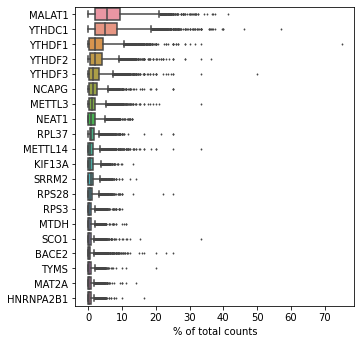

In [13]:
# Plot top 20 most expressed genes 
sc.pl.highest_expr_genes(adata, n_top=20)

## Regular Filtration

In [14]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)
# Calculate max count for each gene
adata.var['max_counts'] = adata.X.max(axis=0)

In [15]:
# Filter cell by area 
# adata = su.filter_cells_by_area(adata, min_area=1000, max_area=100000, save=False)

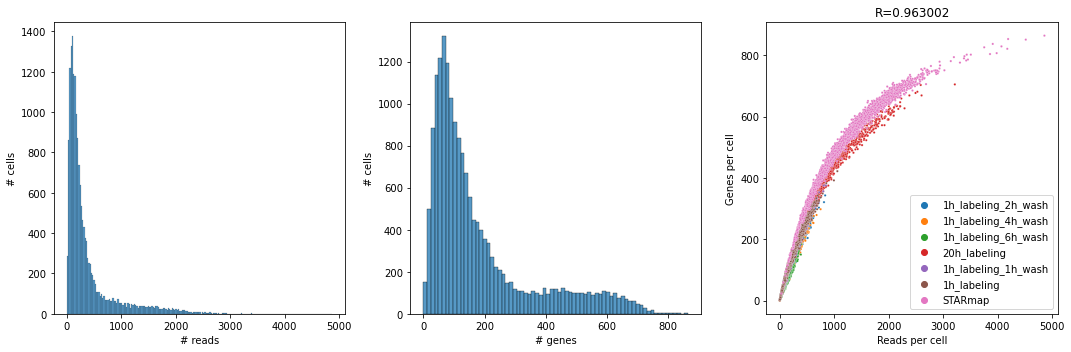

In [16]:
# Per-cell Stats Plot
su.plot_stats_per_cell(adata, save=False)

... storing 'sample' as categorical


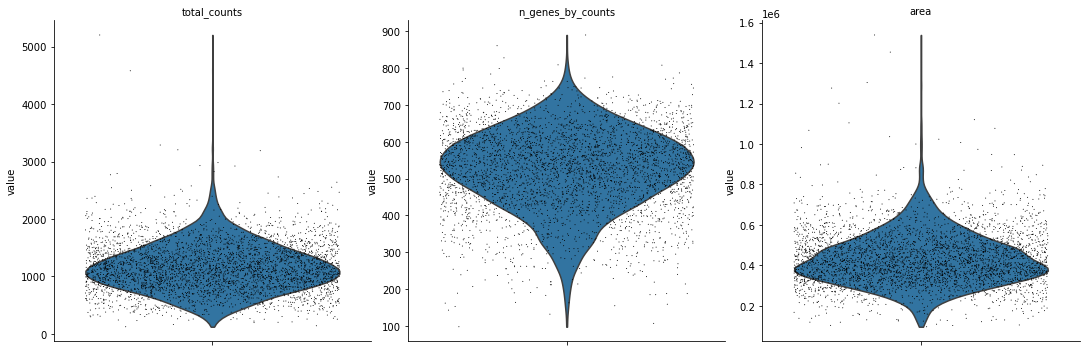

In [31]:
sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'area'],
             jitter=0.4, multi_panel=True)

In [36]:
# Check reads per cell interactively 
import pandas_bokeh
adata.obs.loc[:, ['total_counts']].plot_bokeh.hist(
    bins=np.linspace(0, 8000, 500),
    vertical_xlabel=True,
    hovertool=True,
    line_color="black")

ModuleNotFoundError: No module named 'pandas_bokeh'

In [32]:
# Get quantiles of reads
su.show_reads_quantile(adata)

Reads per cell quantile:
0.10     648.6
0.25     866.5
0.50    1124.0
0.75    1405.5
0.90    1688.0
Name: total_counts, dtype: float64


In [33]:
# Filtration 
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)

# Filter gene by max counts 
# adata = adata[:, adata.var['max_counts'] > 2]
# adata.var['detected'] = adata.var['max_counts'] > 2
# adata.var['highly_variable'] = adata.var['max_counts'] > 2

sc.pp.filter_cells(adata, min_counts=300)
# sc.pp.filter_cells(adata, max_counts=4000)

adata

AnnData object with n_obs × n_vars = 3783 × 991
    obs: 'orig_index', 'sample', 'area', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells'
    layers: 'nucleus', 'cytoplasm', 'er', 'outer_cytoplasm'

## Output

In [17]:
base_path

'Z:/Data/Analyzed/2022-09-06-Rena-TEMPOmap1000GeneHeLa3/'

In [18]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
# adata.write_h5ad(f"{base_path}output/{date}-Hu-HelaRIBOmap-after-pp-300.h5ad")
# adata.write_h5ad(f"{base_path}output/{date}-Hu-HelaSTARmap-after-pp-300.h5ad")
adata.write_h5ad(f"{base_path}output/{date}-Rena-FUCCI-raw.h5ad")

... storing 'sample' as categorical


In [19]:
# adata = sc.read_h5ad(os.path.join(out_path, '2022-02-05-Hu-FUCCI-raw.h5ad'))
adata.obs['Fluo'] = 0
adata.obs['mKO2'] = 0
adata

AnnData object with n_obs × n_vars = 17741 × 998
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Fluo', 'mKO2'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts'
    layers: 'nucleus', 'cytoplasm', 'er', 'outer_cytoplasm'

In [20]:
from starmap.sequencing import *
from tqdm.notebook import tqdm

sample_dict = {
               '1h_labeling_2h_wash': '1h labeling, 2h wash',
               '1h_labeling_4h_wash': '1h labeling, 4h wash',
               '1h_labeling_6h_wash': '1h labeling, 6h wash',
               '20h_labeling': '20h labeling',
               '1h_labeling_1h_wash': '1h labeling, 1h wash',
               '1h_labeling': '1h labeling',
               'STARmap': 'STARmap',
}
sample_dirs = list(sample_dict.keys())

for current_sample in sample_dirs:
    print(current_sample)
    
    index_list = adata.obs.loc[adata.obs['sample'] == current_sample, 'orig_index'].to_list()

    # Load segmentation
    current_seg = load_label_image(os.path.join(base_path, current_sample), fname='nuclei_label.tif')

    # Load fluro image
    mKO_img = load_label_image(os.path.join(base_path, current_sample), fname='mKO.tif')
    mAG_img = load_label_image(os.path.join(base_path, current_sample), fname='mAG.tif')

    # Get region information 
    print('Getting region information...')
    intensity_ch01 = []
    intensity_ch02 = []
    for i, region in enumerate(tqdm(regionprops(current_seg))):
        orig_index = region.label-1
        if orig_index in index_list:
            adata.obs.loc[(adata.obs['orig_index'] == orig_index) & (adata.obs['sample'] == current_sample), 'mKO'] = (mKO_img[region.coords[:, 0], region.coords[:, 1], region.coords[:, 2]]).sum()
            adata.obs.loc[(adata.obs['orig_index'] == orig_index) & (adata.obs['sample'] == current_sample), 'mAG'] = (mAG_img[region.coords[:, 0], region.coords[:, 1], region.coords[:, 2]]).sum()

Getting region information...


  0%|          | 0/2401 [00:00<?, ?it/s]

Getting region information...


  0%|          | 0/2555 [00:00<?, ?it/s]

Getting region information...


  0%|          | 0/3486 [00:00<?, ?it/s]

Getting region information...


  0%|          | 0/1477 [00:00<?, ?it/s]

Getting region information...


  0%|          | 0/2655 [00:00<?, ?it/s]

Getting region information...


  0%|          | 0/2570 [00:00<?, ?it/s]

Getting region information...


  0%|          | 0/2607 [00:00<?, ?it/s]

In [21]:
adata.obs

,orig_index,sample,volume,x,y,z,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,Fluo,mKO2,mKO,mAG
0,0,1h_labeling_2h_wash,223130,42,1495,7,54,4.007333,74.0,4.317488,0,0,638150.0,1179754.0
1,1,1h_labeling_2h_wash,332194,47,1784,10,78,4.369448,123.0,4.820282,0,0,451177.0,2574315.0
2,2,1h_labeling_2h_wash,503831,63,4721,10,109,4.700480,177.0,5.181784,0,0,172210.0,1271848.0
3,3,1h_labeling_2h_wash,84615,32,10613,9,28,3.367296,37.0,3.637586,0,0,170994.0,706202.0
4,4,1h_labeling_2h_wash,193828,41,12873,14,69,4.248495,96.0,4.574711,0,0,1989765.0,1319980.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17746,2602,STARmap,352710,18444,9252,19,328,5.796058,511.0,6.238325,0,0,1213342.0,76838.0
17747,2603,STARmap,347289,18477,9043,16,361,5.891644,626.0,6.440947,0,0,1861352.0,70402.0
17748,2604,STARmap,225505,18469,2662,20,263,5.575949,385.0,5.955837,0,0,29057.0,102150.0
17749,2605,STARmap,196735,18464,2742,21,232,5.451038,328.0,5.796058,0,0,75200.0,244896.0


In [22]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
# adata.write_h5ad(f"{base_path}output/{date}-Hu-HelaRIBOmap-after-pp-300.h5ad")
# adata.write_h5ad(f"{base_path}output/{date}-Hu-HelaSTARmap-after-pp-300.h5ad")
adata.write_h5ad(f"{base_path}output/{date}-Rena-FUCCI-raw.h5ad")

In [23]:
adata

AnnData object with n_obs × n_vars = 17741 × 998
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Fluo', 'mKO2', 'mKO', 'mAG'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts'
    layers: 'nucleus', 'cytoplasm', 'er', 'outer_cytoplasm'